In [626]:
# NBA Contract Value Analysis
## Data Collection, Exploration, and Initial Cleaning

In [627]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
from sqlalchemy import text
import unidecode
# Load environment variables from the .env file
load_dotenv()

#load datasets to sql server

db_url = (
    f"postgresql+psycopg2://{os.getenv('DB_USER')}:{os.getenv('DB_PASSWORD')}"
    f"@{os.getenv('DB_HOST')}:{os.getenv('DB_PORT')}/{os.getenv('DB_NAME')}"
)

engine = create_engine(db_url)

# Connect securely using variables
conn = psycopg2.connect(
    host=os.getenv("DB_HOST"),
    port=os.getenv("DB_PORT"),
    dbname=os.getenv("DB_NAME"),
    user=os.getenv("DB_USER"),
    password=os.getenv("DB_PASSWORD"),
    sslmode="require"
)
cur = conn.cursor()
cur.execute("SELECT version();")  # ask the DB for its version
print(cur.fetchone())             # prints something like ('PostgreSQL 15.x ...',)

cur.close()
conn.close()

# Drop the 'player_value_analysis' view (and any dependencies) before recreating it to prevent error when initially running notebook

with engine.begin() as conn:
    conn.execute(text("DROP VIEW IF EXISTS player_value_analysis CASCADE;"))

('PostgreSQL 17.6 on aarch64-unknown-linux-gnu, compiled by gcc (GCC) 13.2.0, 64-bit',)


In [628]:
stats = pd.read_csv("../data/raw/nba_stats_2025.csv")
contracts = pd.read_csv("../data/raw/nba_salaries_2025.csv")
adv = pd.read_csv("../data/raw/nba_advanced_2025.csv")

pd.read_sql("SELECT COUNT(*) FROM contracts", engine)

#print(stats.shape)
#print(stats.head())
#print(contracts.shape)
#print(contracts.head())

,count
0,536


In [629]:
## Cleaning Player Stats Dataset

In [630]:
# Rename columns for standardized querying
stats = stats.rename(columns={
    "Rk": "rank",
    "Player": "player",
    "Age": "age",
    "Team": "team",
    "Pos": "position",
    "G": "games",
    "GS": "games_started",
    "MP": "minutes_per_game",
    "FG": "fg_made",
    "FGA": "fg_attempts",
    "FG%": "fg_pct",
    "3P": "three_p_made",
    "3PA": "three_p_attempts",
    "3P%": "three_p_pct",
    "2P": "two_p_made",
    "2PA": "two_p_attempts",
    "2P%": "two_p_pct",
    "eFG%": "efg_pct",
    "FT": "ft_made",
    "FTA": "ft_attempts",
    "FT%": "ft_pct",
    "ORB": "off_rebounds",
    "DRB": "def_rebounds",
    "TRB": "total_rebounds",
    "AST": "assists",
    "STL": "steals",
    "BLK": "blocks",
    "TOV": "turnovers",
    "PF": "personal_fouls",
    "PTS": "points_per_game",
    "Player-additional": "player_id"   # keep as join key
})
print(stats.columns.tolist())

['rank', 'player', 'age', 'team', 'position', 'games', 'games_started', 'minutes_per_game', 'fg_made', 'fg_attempts', 'fg_pct', 'three_p_made', 'three_p_attempts', 'three_p_pct', 'two_p_made', 'two_p_attempts', 'two_p_pct', 'efg_pct', 'ft_made', 'ft_attempts', 'ft_pct', 'off_rebounds', 'def_rebounds', 'total_rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'personal_fouls', 'points_per_game', 'Awards', 'player_id']


In [631]:
# CLean nba stats data set to no longer include "NaN" and change type from float to Int
stats = stats[stats["rank"].notna()]
stats["rank"] = stats["rank"].astype("Int64")

In [632]:
#  Remove duplicate rows for multi-team players (2TM, 3TM)
#  Identify all players with combined season rows ("2TM", "3TM")
#  Drop their individual team rows (DAL, LAL, etc.)
#  Keep only their multi-team total row for the full-season summary
multi_team_players = stats[stats["team"].str.contains("TM")]["player"].unique()
stats = stats[~((stats["player"].isin(multi_team_players)) & (~stats["team"].str.contains("TM")))
]

In [633]:
# Check for amount of multi-team players
print("Number of multi-team players:", len(multi_team_players))
# multi_team_players.head(10)

Number of multi-team players: 81


In [634]:
# Columns should be integers, then confirm
int_cols =["rank", "games", "age", "games_started"] 
stats[int_cols] = stats[int_cols].astype("Int64")
stats.dtypes[int_cols]

rank             Int64
games            Int64
age              Int64
games_started    Int64
dtype: object

In [635]:
### Dropping `Awards` Column
# The `Awards` column was removed because:
# - It contained inconsistent strings (e.g., "MVP-10" = 10th in MVP voting, not an actual MVP award).
# - Many `2TM` summary rows were missing awards, leading to incomplete or misleading data.
# - Awards are subjective recognition and less relevant to our core analysis (salary vs. performance).
# By removing this column, we simplify the dataset and focus on reliable, objective performance metrics.
stats = stats.drop(columns=["Awards"], errors="ignore")

In [636]:
"Awards" in stats.columns

False

In [637]:
# Filter out low participation players
#stats = stats[(stats["games"] >= 41) & (stats["minutes_per_game"] >= 10)]

In [638]:
# Clean names in stats dataset
stats["player"] = stats["player"].apply(unidecode.unidecode)
stats["player"] = stats["player"].str.strip()

In [639]:
# Remove duplicates and reset index
stats = stats.drop_duplicates(subset=["player", "team"])
stats = stats.reset_index(drop=True)

In [640]:
# Final Check
print("Final dataset shape:", stats.shape)
print(stats.head())

Final dataset shape: (569, 31)
   rank                   player  age team position  games  games_started  \
0     1  Shai Gilgeous-Alexander   26  OKC       PG     76             76   
1     2    Giannis Antetokounmpo   30  MIL       PF     67             67   
2     3             Nikola Jokic   29  DEN        C     70             70   
3     4              Luka Doncic   25  2TM       PG     50             50   
4     5          Anthony Edwards   23  MIN       SG     79             79   

   minutes_per_game  fg_made  fg_attempts  ...  off_rebounds  def_rebounds  \
0              34.2     11.3         21.8  ...           0.9           4.1   
1              34.2     11.8         19.7  ...           2.2           9.7   
2              36.7     11.2         19.5  ...           2.9           9.9   
3              35.4      9.2         20.5  ...           0.8           7.4   
4              36.3      9.1         20.4  ...           0.8           4.9   

   total_rebounds  assists  steals  b

In [641]:
# After cleaning, saved the processed dataset into a separate folder
stats.to_csv("../data/clean/nba_stats_clean.csv", index=False)
print("Cleaned dataset saved successfully.")

Cleaned dataset saved successfully.


In [642]:
# Cleaning advanced stats data set
# Format advanced stats column names for SQL querying 

adv = adv.rename(columns={
    "Rk": "rank",
    "Player": "player",
    "Age": "age",
    "Team": "team",
    "Pos": "position",
    "G": "games",
    "GS": "games_started",
    "MP": "minutes_played",
    "PER": "per",
    "TS%": "ts_pct",
    "3PAr": "threepar",
    "FTr": "ftr",
    "ORB%": "orb_pct",
    "DRB%": "drb_pct",
    "TRB%": "trb_pct",
    "AST%": "ast_pct",
    "STL%": "stl_pct",
    "BLK%": "blk_pct",
    "TOV%": "tov_pct",
    "USG%": "usg_pct",
    "OWS": "ows",
    "DWS": "dws",
    "WS": "ws",
    "WS/48": "ws_per_48",
    "OBPM": "obpm",
    "DBPM": "dbpm",
    "BPM": "bpm",
    "VORP": "vorp",
    "Awards": "awards",
    "Player-additional": "player_id"
})

print(adv.columns.tolist())

['rank', 'player', 'age', 'team', 'position', 'games', 'games_started', 'minutes_played', 'per', 'ts_pct', 'threepar', 'ftr', 'orb_pct', 'drb_pct', 'trb_pct', 'ast_pct', 'stl_pct', 'blk_pct', 'tov_pct', 'usg_pct', 'ows', 'dws', 'ws', 'ws_per_48', 'obpm', 'dbpm', 'bpm', 'vorp', 'awards', 'player_id']


In [643]:
# Cleaning advanced stats data set

# Identify players who have a total multi-team row (e.g., "2TM", "3TM", "4TM", etc.)
multi_team_players_adv = adv[adv["team"].str.contains("tm", case=False, na=False)]["player"].unique()

# Remove their team-specific rows (e.g., BRK, DET, GSW), keeping only their "2TM"/"3TM" row
adv = adv[~((adv["player"].isin(multi_team_players_adv)) & (~adv["team"].str.contains("tm", case=False, na=False)))
]

In [644]:
# Convert numeric columns to correct types
int_cols = ["rank", "age", "games", "games_started", "minutes_played"]
float_cols = [
    "per", "ts_pct", "threepar", "ftr", "orb_pct", "drb_pct", "trb_pct",
    "ast_pct", "stl_pct", "blk_pct", "tov_pct", "usg_pct",
    "ows", "dws", "ws", "ws_per_48", "obpm", "dbpm", "bpm", "vorp"
]

adv[int_cols] = adv[int_cols].apply(pd.to_numeric, errors="coerce").astype("Int64")
adv[float_cols] = adv[float_cols].apply(pd.to_numeric, errors="coerce")

In [645]:
# Clean names in advanced stats dataset
adv["player"] = adv["player"].apply(unidecode.unidecode)
adv["player"] = adv["player"].str.strip()

In [646]:
# Remove duplicates and reset index
adv = adv.drop_duplicates(subset=["player", "team"])
adv = adv.reset_index(drop=True)

In [647]:
# Dropping `Awards` Column
adv = adv.drop(columns=["awards"], errors="ignore")
"awards" in adv.columns

False

In [648]:
# Final Check
print("Final dataset shape:", adv.shape)
print(adv.head())

Final dataset shape: (570, 29)
   rank           player  age team position  games  games_started  \
0     1    Mikal Bridges   28  NYK       SF     82             82   
1     2        Josh Hart   29  NYK       SG     77             77   
2     3  Anthony Edwards   23  MIN       SG     79             79   
3     4     Devin Booker   28  PHO       SG     75             75   
4     5     James Harden   35  LAC       PG     79             79   

   minutes_played   per  ts_pct  ...  usg_pct  ows  dws   ws  ws_per_48  obpm  \
0            3036  14.0   0.585  ...     19.6  3.7  2.0  5.7      0.090   0.4   
1            2897  16.5   0.611  ...     15.3  5.4  3.8  9.2      0.153   1.1   
2            2871  20.1   0.595  ...     31.4  4.6  3.8  8.4      0.140   4.4   
3            2795  19.3   0.589  ...     29.3  6.1  0.3  6.4      0.111   2.8   
4            2789  20.0   0.582  ...     29.6  4.0  4.3  8.3      0.143   3.5   

   dbpm  bpm  vorp  player_id  
0  -0.9 -0.5   1.2  bridgmi01  
1  

In [649]:
# After cleaning, saved the processed dataset into a separate folder
adv.to_csv("../data/clean/nba_adv_stats_clean.csv", index=False)
print("Cleaned dataset saved successfully.")

Cleaned dataset saved successfully.


In [650]:
# Cleaning player salaries data set

In [651]:
# Rename contracts column names

contracts = contracts.rename(columns={
    "Player": "player",
    "Team": "team",
    "Salary": "salary"
})

In [652]:
# Clean salary column, Remove $ and commas, Strip whitespace, Convert to integer

contracts["salary"] = (
    contracts["salary"]
    .astype(str)
    .str.replace("$", "", regex=False)
    .str.replace(",", "", regex=False)
    .str.strip()
    .astype(int)
    )

contracts.head()

,player,team,salary
0,Stephen Curry,GSW,55761216
1,Joel Embiid,PHI,51415938
2,Nikola Jokic,DEN,51415938
3,Kevin Durant,PHO,51179021
4,Bradley Beal,PHO,50203930


In [653]:
# Standardize texts for consistency and drop duplicates
contracts["player"] = contracts["player"].str.strip()
contracts["team"] = contracts["team"].str.strip().str.upper()
contracts = contracts.drop_duplicates(subset=["player", "team"])

contracts.head()

,player,team,salary
0,Stephen Curry,GSW,55761216
1,Joel Embiid,PHI,51415938
2,Nikola Jokic,DEN,51415938
3,Kevin Durant,PHO,51179021
4,Bradley Beal,PHO,50203930


In [654]:
# Check for missing values and standardize column name for querying
print(contracts.isnull().sum())

player    0
team      0
salary    0
dtype: int64


In [655]:
# After cleaning, saved the processed dataset into a separate folder
contracts.to_csv("../data/clean/nba_contracts_clean.csv", index=False)
print("Cleaned dataset saved successfully.")

Cleaned dataset saved successfully.


In [656]:
# Send clean data sets to SQL database
stats.to_sql("stats", engine, if_exists="replace", index=False)
contracts.to_sql("contracts", engine, if_exists="replace", index=False)
adv.to_sql("adv", engine, if_exists="replace", index=False)

570

In [657]:
# Connect notebook to SQL join query files

with open("../sql/join_stats_contracts.sql", "r") as file:
    query = file.read()

joined_df = pd.read_sql(query, engine)
joined_df.tail()

,rank,player,age,team,position,games,games_started,minutes_per_game,fg_made,fg_attempts,...,def_rebounds,total_rebounds,assists,steals,blocks,turnovers,personal_fouls,points_per_game,player_id,salary
503,214,Zach Edey,22,MEM,C,66,55,21.5,3.8,6.6,...,4.8,8.3,1.0,0.5,1.3,1.3,2.8,9.2,edeyza01,5756880
504,29,Zach LaVine,29,2TM,SG,74,74,35.2,8.4,16.5,...,4.0,4.3,4.2,0.8,0.2,2.8,1.6,23.3,lavinza01,44531940
505,462,Zeke Nnaji,24,DEN,PF,57,4,10.7,1.2,2.5,...,1.0,1.6,0.4,0.4,0.7,0.2,1.1,3.2,nnajize01,8888889
506,192,Ziaire Williams,23,BRK,SF,63,45,24.5,3.4,8.3,...,3.6,4.6,1.3,1.0,0.4,1.1,2.4,10.0,willizi02,6133005
507,17,Zion Williamson,24,NOP,PF,30,30,28.6,9.6,16.9,...,4.7,7.2,5.3,1.2,0.9,3.0,2.7,24.6,willizi01,36725670


In [658]:
with open("../sql/check_unmatched_players.sql", "r") as file:
    query = file.read()

pd.set_option("display.max_rows", 1000)

df_check = pd.read_sql(query, engine)
display(df_check)

,category,player
0,Stats but not Contracts,Tolu Smith
1,Stats but not Contracts,Keion Brooks Jr.
2,Stats but not Contracts,Tosan Evbuomwan
3,Stats but not Contracts,Tristan Vukcevic
4,Stats but not Contracts,Tyson Etienne
5,Stats but not Contracts,KJ Simpson
6,Stats but not Contracts,Oscar Tshiebwe
7,Stats but not Contracts,Damion Baugh
8,Stats but not Contracts,Daeqwon Plowden
9,Stats but not Contracts,Jeff Dowtin Jr.


In [659]:
# Opened up SQL file that ran the player value analysis view and now commented out to mitigate unnecessary error when running notebook
with engine.begin() as conn:
    conn.execute(text(open("../sql/player_value_analysis.sql").read()))

In [660]:
query = "SELECT * FROM player_value_analysis ORDER BY salary ASC LIMIT 10;"
df_value_analysis = pd.read_sql(query, engine)
display(df_value_analysis)

,player,team,position,games,mpg,ppg,ast,reb,salary,salary_tier,per,ts_pct,ws,bpm,vorp
0,Jamison Battle,TOR,SF,59,17.7,7.1,0.9,2.7,1000000,Minimum,10.7,0.590,1.7,-2.3,-0.1
1,Ryan Rollins,MIL,PG,56,14.6,6.2,1.9,1.9,1091887,Minimum,14.0,0.600,1.7,-0.5,0.3
2,Ryan Rollins,MIL,PG,56,14.6,6.2,1.9,1.9,1091887,Minimum,14.0,0.600,1.7,-0.5,0.3
3,Adem Bona,PHI,C,58,15.6,5.8,0.5,4.2,1157153,Minimum,16.5,0.714,2.3,-2.7,-0.2
4,Oso Ighodaro,PHO,PF,61,17.1,4.2,1.2,3.6,1157153,Minimum,11.1,0.610,1.6,-2.6,-0.2
5,Pelle Larsson,MIA,SG,55,14.2,4.6,1.2,1.7,1157153,Minimum,10.2,0.546,1.4,-3.1,-0.2
6,Jaylen Wells,MEM,SG,79,25.9,10.4,1.7,3.4,1157153,Minimum,10.5,0.560,3.5,-2.2,-0.1
7,Landry Shamet,NYK,SG,50,15.2,5.7,0.5,1.2,1343690,Minimum,9.7,0.601,1.0,-2.4,-0.1
8,Karlo Matkovic,NOP,PF,42,18.8,7.7,1.1,5.0,1407153,Minimum,15.6,0.639,1.6,-2.0,0.0
9,Orlando Robinson,2TM,C,44,17.5,6.9,1.8,5.0,1691610,Minimum,12.9,0.519,1.2,-3.4,-0.3


In [661]:
### Correlation Analysis
### We will now explore how player performance metrics (PER, WS, VORP, BPM, TS%) relate to salary.

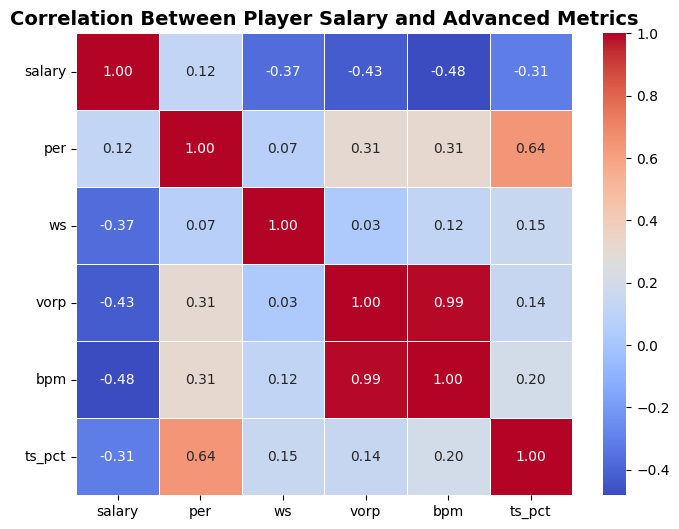

In [662]:
correlation_matrix = df_value_analysis[["salary", "per", "ws", "vorp", "bpm", "ts_pct"]].corr()
correlation_matrix

plt.figure(figsize=(8,6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Player Salary and Advanced Metrics", fontsize=14, weight="bold")
plt.yticks(rotation=0)
plt.show()

In [663]:
with open("../sql/pva_averages.sql", "r") as file:
    query = file.read()

averages_df = pd.read_sql(query, engine)
display(averages_df)

,position,player_count,avg_salary,avg_per,avg_ws,avg_vorp
0,PG,56,18349483.91,15.48,3.84,1.34
1,PF,62,15160742.26,15.45,3.54,1.05
2,SF,52,13411819.77,14.15,3.35,0.68
3,C,72,12966715.26,18.02,4.34,1.23
4,SG,83,11288350.78,13.61,3.40,0.83


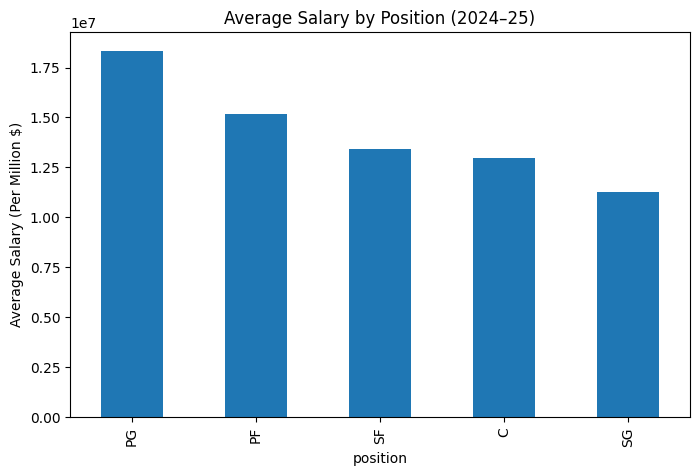

In [664]:
pos_summary = pd.read_sql(open("../sql/pva_averages.sql").read(), engine)

pos_summary.plot(
    x="position",
    y="avg_salary",
    kind="bar",
    title="Average Salary by Position (2024–25)",
    figsize=(8, 5),
    legend=False
)
plt.ylabel("Average Salary (Per Million $)")
plt.show()

C:\Users\Hundo\AppData\Local\Temp\ipykernel_6148\4212675036.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ws_eff, x="ws_per_million", y="player", palette="viridis")


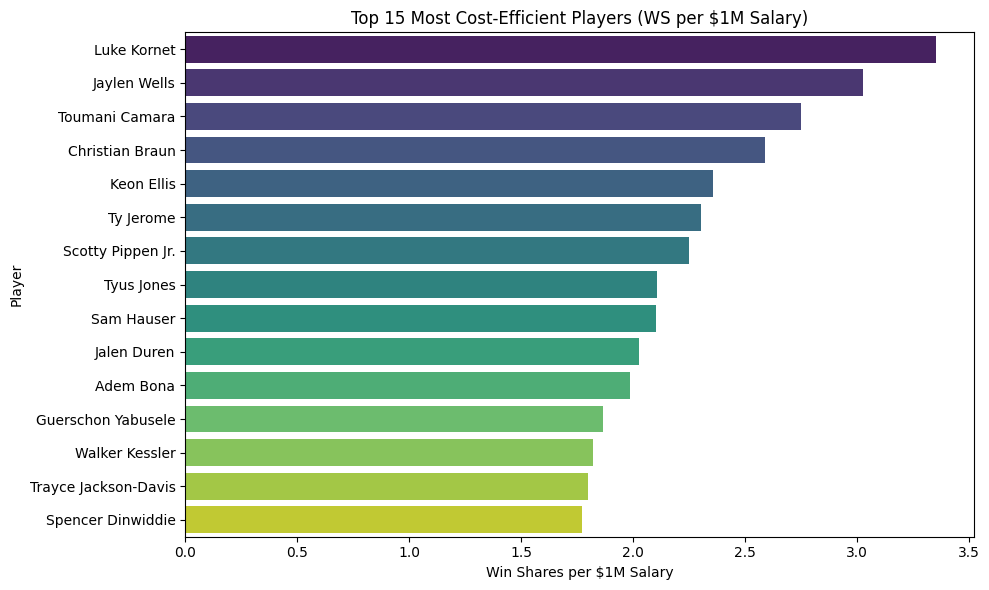

In [665]:
# Load queries that analyze win shares per million, per against salary and true shooting percentage against salary

ws_eff = pd.read_sql(open("../sql/ws_per_million.sql").read(), engine)
per_eff = pd.read_sql(open("../sql/per_vs_salary.sql").read(), engine)
ts_eff = pd.read_sql(open("../sql/ts_pct_vs_salary.sql").read(), engine)

plt.figure(figsize=(10, 6))
sns.barplot(data=ws_eff, x="ws_per_million", y="player", palette="viridis")
plt.title("Top 15 Most Cost-Efficient Players (WS per $1M Salary)")
plt.xlabel("Win Shares per $1M Salary")
plt.ylabel("Player")
plt.tight_layout()
plt.show()

